Machine learning code for clickbait detector alogorithm based on 'Clickbait Classifier using LSTM' by user 'atechnohazard' found on Kaggle under the 'kernels' tab of the dataset we used. All other code is original work. https://www.kaggle.com/atechnohazard/clickbait-classifier-using-lstm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import json
from nltk.corpus import stopwords
import string as s

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
FILE_PATH = 'new resources/clickbait_data.csv'
data = pd.read_csv(FILE_PATH)
data

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [3]:
# processing headlines to optimize model performance

text = data['headline'].values
labels = data['clickbait'].values

stpwrds = set(stopwords.words('english'))
new_text =[]

_digits_ = str.maketrans('', '', s.digits)

# loop to remove all stopwords and digits from headlines (head)

for head in text:
    head = head.translate(_digits_)
    head = head.lower()
    head = ' '.join(list(set(re.split("\W+",head)) - stpwrds))
    new_text.append(head)
    
# splitting and tokenizing all headlines, using pad_sequences to create uniform length by adding null values to the end
    
text_train, text_test, y_train, y_test = train_test_split(new_text, labels)

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(new_text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)

X_train = pad_sequences(X_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)

In [4]:
text_train[0:20]

['video new bbc released alan  wearing belt explosive shows johnston journalist',
 'pretend exist pretending us',
 'discover police iraqi bodies',
 'disney would like life movie',
 'push th three walks braves past mets',
 'journalists dangers face ups freelancers start',
 ' fruit people freakin love gifts',
 'france air recorders flight found',
 'ultimate fangirls bardem u stage penelope cruz javier',
 'bryan bad station breaking cranston dvds send tried space international',
 ' clean life gifts freak',
 ' christmas would questions rather answer impossible',
 ' add extra cook everything ways flavor',
 'people take holiday photos honest single',
 'wrap happened battle compete celebrities',
 'public confrontations violent results golf courses often rage',
 'legalizes sex marriage spain',
 ' girls things american british jealous teens insanely',
 'grids bargaining smart utility customers power give',
 'action rak face thai sondhi legal may party']

In [5]:
n = []

for h in text:
    n.extend(h.split(' '))
    
vocab = len(pd.Series(n).unique())

In [6]:
# creating the model

model = Sequential()
model.add(Embedding(vocab+1, 32, input_length=100))
model.add(LSTM(32, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           1145312   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           8320      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,153,665
Trainable params: 1,153,665
Non-trainable params: 0
_________________________________________________________________


In [7]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights.h5',
        monitor='val_accuracy', 
        mode='max', 
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train, 
                    batch_size=512, 
                    validation_data=(x_test, y_test), 
                    epochs=20, 
                    callbacks=callbacks)

Epoch 1/20
47/47 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.7685
Epoch 00001: val_accuracy improved from -inf to 0.93163, saving model to weights.h5
47/47 [==============================] - 23s 479ms/step - loss: 0.6625 - accuracy: 0.7685 - val_loss: 0.5717 - val_accuracy: 0.9316
Epoch 2/20
47/47 [==============================] - ETA: 0s - loss: 0.3942 - accuracy: 0.9308
Epoch 00002: val_accuracy improved from 0.93163 to 0.94638, saving model to weights.h5
47/47 [==============================] - 23s 486ms/step - loss: 0.3942 - accuracy: 0.9308 - val_loss: 0.2300 - val_accuracy: 0.9464
Epoch 3/20
47/47 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9649
Epoch 00003: val_accuracy improved from 0.94638 to 0.95538, saving model to weights.h5
47/47 [==============================] - 22s 477ms/step - loss: 0.1588 - accuracy: 0.9649 - val_loss: 0.1458 - val_accuracy: 0.9554
Epoch 4/20
47/47 [==============================] - ETA: 0s - lo

In [9]:
model.load_weights('weights.h5')
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


<Figure size 432x288 with 0 Axes>

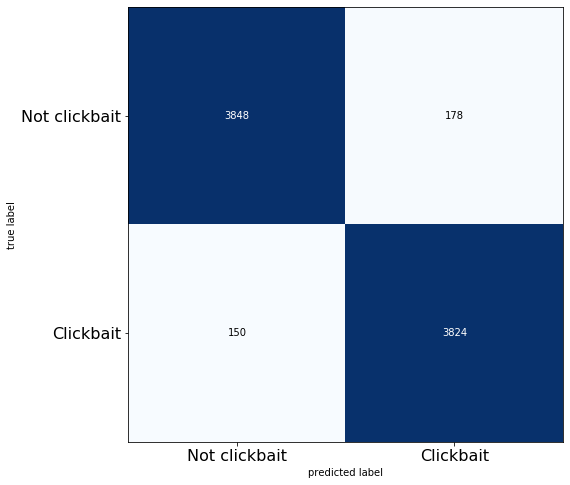

In [10]:
preds = [round(i[0]) for i in model.predict(x_test)]
cm = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=16)
plt.show()

In [11]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.96
Precision of the model is 0.96


In [12]:
# function that takes in a list of headlines and returns both the binary prediction and the label for each

def predict(test):
    labels = []
    predicts = []
    for t in test:
        t = t.translate(_digits_)
        t = t.lower()
        t = ' '.join(list(set(re.split("\W+",t)) - stpwrds))
    token_text = pad_sequences(tokenizer.texts_to_sequences(test), maxlen=100)

    preds = [round(i[0]) for i in model.predict(token_text)]
    for (text, pred) in zip(test, preds):
        label = 'Clickbait' if pred == 1.0 else 'Not Clickbait'
        labels.append(label)
        predicts.append(pred)
        
    return [labels, predicts]


In [13]:
master = pd.read_csv('cleaned_articles.csv')

In [14]:
category = []
urls=[]

# stripping filepath to yield category, as well as processing the url column to yield the source of the article

for f in master['filename']:
    category.append(f.replace('new resources\project-','').replace('.csv',''))
for u in master['url']:
    u = u.replace(
        'https://', '').replace(
        'www.', '').replace(
        'http://', '').split(
        ".com")[0]
    if '.net' in u:
        u = u.split('.net')[0]
    
    urls.append(u)
    
    
del master['filename']
del master['url']

master['Category'] = category
master['Source'] = urls


In [15]:
clean = master.dropna(subset=['title'])

In [ ]:
clean['Clickbait'] = predict(clean['title'])[0]
clean['Clickbait binary'] = predict(clean['title'])[1]

In [17]:
clickcat = clean.groupby(['Category', 'Clickbait'])

In [78]:
b = pd.DataFrame({
    'Mean Shares per Article' : clickcat['total_facebook_shares'].mean(),
    'Mean Likes per Article' : clickcat['facebook_likes'].mean(),
})
b = b[['Mean Likes per Article']]

In [79]:
b

Mean Likes per Article
Category         Clickbait                            
blacklivesmatter Clickbait                20472.590800
                 Not Clickbait            25231.484646
covid            Clickbait               137736.948837
                 Not Clickbait           122003.601403
education        Clickbait                 4200.786932
                 Not Clickbait             3135.287952
entertainment    Clickbait                31040.563945
                 Not Clickbait            39573.192504
fitness          Clickbait                  675.236591
                 Not Clickbait             1044.421923
food             Clickbait                12160.373614
                 Not Clickbait             8459.758144
health           Clickbait                33013.090622
                 Not Clickbait            29799.778080
politics         Clickbait                72282.831176
                 Not Clickbait            84166.912477
sports           Clickbait                19891.462191
                 Not Clickbait            19500.841729
technology       Clickbait                 3675.117188
                 Not Clickbait             2248.077002
trump            Clickbait                45050.744689
                 Not Clickbait            51713.277560

In [21]:
source = clean.groupby('Source')

In [22]:
source['title'].count()

Source
100percentfedup        26
1010wins.radio          6
1011now                 9
1015thehawk             1
101blockchains          1
                       ..
zondervan               1
zoomtventertainment     8
zora.medium             6
zters                   1
zumba                   1
Name: title, Length: 7913, dtype: int64

In [68]:
s = pd.DataFrame({'Count' : source['title'].count(),
                  'Likes per Article' : source['facebook_likes'].mean(),
                  'Clickbait' : 100*source['Clickbait binary'].mean()
                  
})
s

,Count,Likes per Article,Clickbait
Source,,,
100percentfedup,26,8213.076923,11.538462
1010wins.radio,6,38361.333333,16.666667
1011now,9,3219.222222,0.000000
1015thehawk,1,289.000000,0.000000
101blockchains,1,3.000000,0.000000
...,...,...,...
zondervan,1,249.000000,100.000000
zoomtventertainment,8,1723.125000,50.000000
zora.medium,6,7527.500000,83.333333


In [69]:
new_s = s.sort_values(by='Count', ascending=False)

In [70]:
new_s

,Count,Likes per Article,Clickbait
Source,,,
youtube,8356,14084.759454,53.901388
cnn,3985,65826.917942,27.202008
foxnews,3623,74008.637317,13.993928
thehill,2645,48243.693762,20.529301
nytimes,2313,63026.594898,26.415910
...,...,...,...
myneworleans,1,360.000000,0.000000
currentnewsnow,1,49223.000000,0.000000
currentwellnessraleigh,1,34.000000,100.000000


In [71]:
top10 = new_s.iloc[0:10]

Text(0.5, 1.0, 'Percent of Results with Clickbait Titles Across Top 10 Sources')

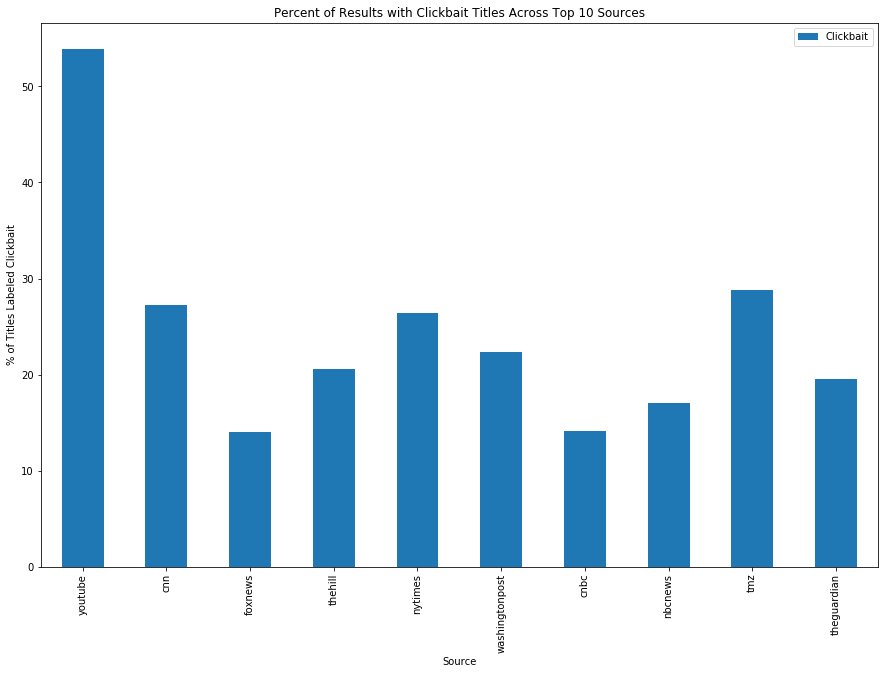

In [74]:
top10 = top10[['Clickbait']]
top10.plot(kind='bar', figsize=(15, 10))
plt.ylabel('% of Titles Labeled Clickbait')
plt.title('Percent of Results with Clickbait Titles Across Top 10 Sources')

In [46]:
baitcat = clean[clean['Clickbait binary'] == 1].groupby('Category')

In [47]:
nobaitcat = clean[clean['Clickbait binary'] == 0].groupby('Category')

Text(0.5, 1.0, 'Mean Likes for Clickbait and Not Clickbait Titles Across 11 Categories')

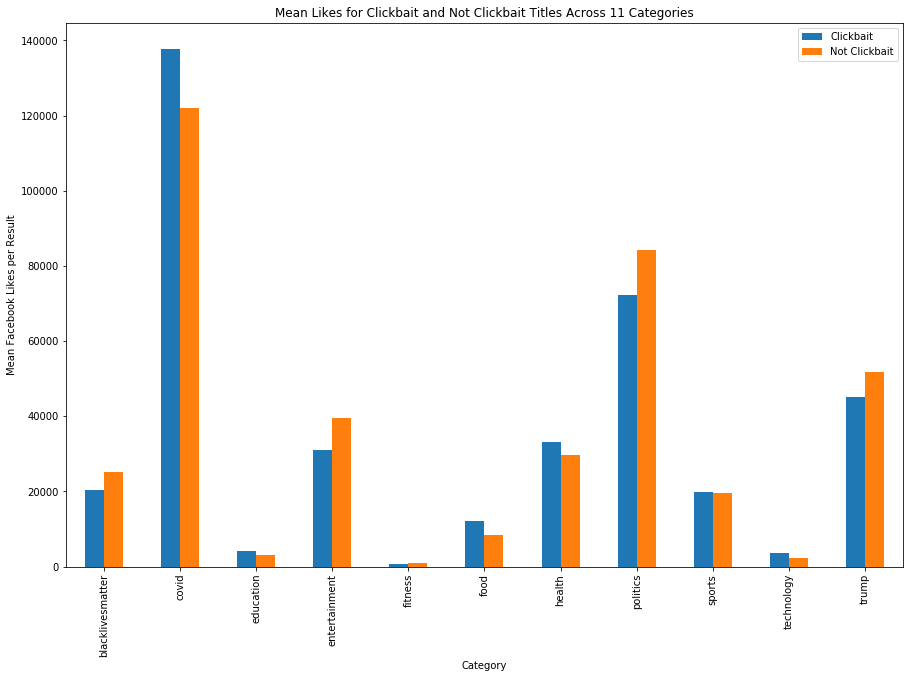

In [75]:
f_likes = pd.DataFrame({
    'Clickbait' : baitcat['facebook_likes'].mean(),
    'Not Clickbait' : nobaitcat['facebook_likes'].mean()
})

f_likes.plot.bar(figsize=(15,10))
plt.ylabel('Mean Facebook Likes per Result')
plt.title('Mean Likes for Clickbait and Not Clickbait Titles Across 11 Categories')

In [57]:
angry = clean[clean['angry_count'] > 0]

In [58]:
angrybaitcat = angry[angry['Clickbait binary'] == 1].groupby('Category')
noangrybaitcat = angry[angry['Clickbait binary'] == 0].groupby('Category')

Text(0.5, 1.0, 'Angry Reactions to Clickbait and Non-Clickbait Titles Across 11 Categories')

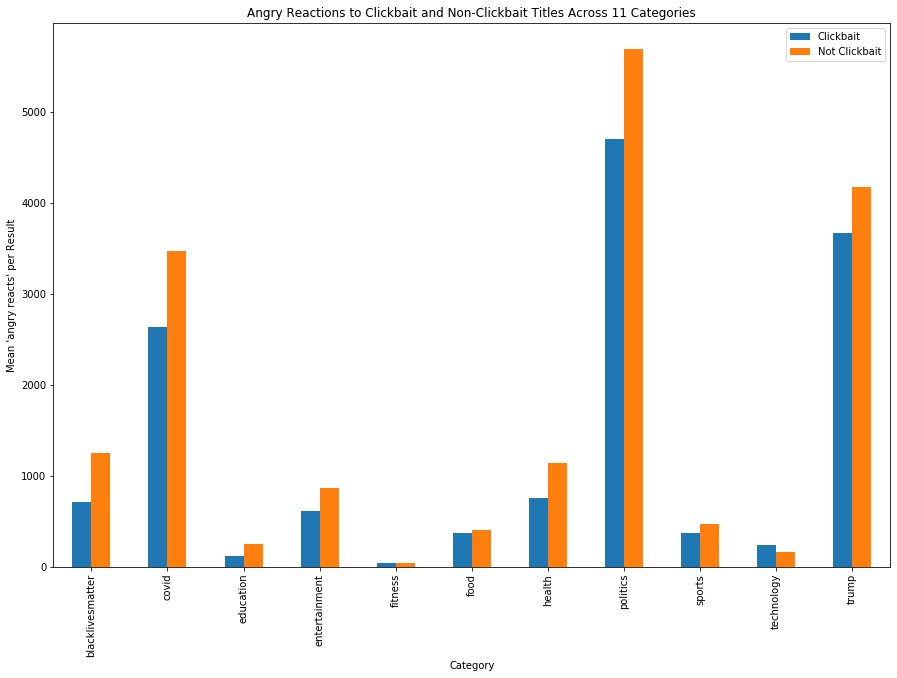

In [76]:
f_angry = pd.DataFrame({
    'Clickbait' : angrybaitcat['angry_count'].mean(),
    'Not Clickbait' : noangrybaitcat['angry_count'].mean()
})

f_angry.plot.bar(figsize=(15, 10))
plt.ylabel("Mean 'angry reacts' per Result")
plt.title('Angry Reactions to Clickbait and Non-Clickbait Titles Across 11 Categories')